In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [2]:
dataset = 'datasets/keypoint1000.csv'
model_save_path = 'models/keypoint_classifier.hdf5'
tflite_save_path = 'models/keypoint_classifier_part1.tflite'
tflite_save_path2 = 'models/keypoint_classifier_part2.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 12
LABELS = ['call', 'dislike', 'fist', 'like', 'mute', 'ok', 'one', 'palm', 'peace', 'rock', 'stop', 'stop_inverted'] 

# Dataset reading

In [4]:
def apply_rotation(label, points):
    num_points = 21
    point_0 = points[0]
    point_8 = points[8]

    if label == 'dislike' or label == 'like':
        return points  # No rotation
    elif label == 'call':
        # Rotate to be parallel with X-axis
        line = point_8 - point_0
        angle = np.arctan2(line[2], line[0])  # Consider the X-Z plane
        rotation_matrix = np.array([
            [1, 0, 0],
            [0, np.cos(angle), -np.sin(angle)],
            [0, np.sin(angle), np.cos(angle)]
        ])
    else:
        # Rotate to be parallel with Y-axis
        line = point_8 - point_0
        angle = np.arctan2(line[2], line[1])  # Consider the Y-Z plane
        rotation_matrix = np.array([
            [np.cos(angle), 0, np.sin(angle)],
            [0, 1, 0],
            [-np.sin(angle), 0, np.cos(angle)]
        ])
    
    # Apply rotation
    for i in range(num_points):
        points[i] = np.dot(rotation_matrix, points[i])

    return points


In [5]:
def pre_process_dataset(X_dataset, y_dataset):
    # Reshape to 3D
    num_points = 21
    # reshaped_dataset = X_dataset.reshape(-1, num_points, 3)

    # # Shift coordinates
    # for i in range(len(reshaped_dataset)):
    #     base_point = reshaped_dataset[i, 0]  # ID:0
    #     for j in range(num_points):
    #         reshaped_dataset[i, j] -= base_point

    # # Rotation
    # for i in range(len(reshaped_dataset)):
    #     label = LABELS[y_dataset[i]]
    #     reshaped_dataset[i] = apply_rotation(label, reshaped_dataset[i])

    # Flatten
    # flattened_dataset = reshaped_dataset.reshape(-1, num_points * 3)

    # # Normalization
    # max_abs_value = np.max(np.abs(flattened_dataset))
    # normalized_dataset = flattened_dataset / max_abs_value

    X_dataset[2] = 0

    return X_dataset

In [6]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 3) + 1)))

In [7]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [8]:
X_dataset_preprocessed = pre_process_dataset(X_dataset, y_dataset)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset_preprocessed, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 3, )),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),  # Increased units
    tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
    tf.keras.layers.Dropout(0.1),  # Adjusted dropout rate
    tf.keras.layers.Dense(128, activation='relu'),  # Increased units
    tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
    tf.keras.layers.Dense(64, activation='relu'),  # Increased units
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [11]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 63)                0         
                                                                 
 dense (Dense)               (None, 128)               8192      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                       

In [12]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=30, verbose=1)

In [13]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [14]:
es_callback

In [15]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000




71/71 [==============================] - ETA: 0s - loss: 2.3848 - accuracy: 0.1909
Epoch 1: saving model to models\keypoint_classifier.hdf5
71/71 [==============================] - 3s 8ms/step - loss: 2.3848 - accuracy: 0.1909 - val_loss: 2.4232 - val_accuracy: 0.2060
Epoch 2/1000
37/71 [==============>...............] - ETA: 0s - loss: 2.1006 - accuracy: 0.2793

c:\Users\Ian\git\553.806_Capstone_HandGesture\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/71 [============================>.] - ETA: 0s - loss: 2.0525 - accuracy: 0.2904
Epoch 2: saving model to models\keypoint_classifier.hdf5
71/71 [==============================] - 0s 5ms/step - loss: 2.0498 - accuracy: 0.2910 - val_loss: 2.2424 - val_accuracy: 0.2790
Epoch 3/1000
70/71 [============================>.] - ETA: 0s - loss: 1.8521 - accuracy: 0.3666
Epoch 3: saving model to models\keypoint_classifier.hdf5
71/71 [==============================] - 0s 4ms/step - loss: 1.8525 - accuracy: 0.3666 - val_loss: 1.9515 - val_accuracy: 0.3730
Epoch 4/1000
67/71 [===========================>..] - ETA: 0s - loss: 1.7173 - accuracy: 0.4256
Epoch 4: saving model to models\keypoint_classifier.hdf5
71/71 [==============================] - 0s 5ms/step - loss: 1.7166 - accuracy: 0.4248 - val_loss: 1.8035 - val_accuracy: 0.3727
Epoch 5/1000
55/71 [======================>.......] - ETA: 0s - loss: 1.5658 - accuracy: 0.4700
Epoch 5: saving model to models\keypoint_classifier.hdf5
71/71 [=======

In [16]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

24/24 [==============================] - 0s 2ms/step - loss: 0.1947 - accuracy: 0.9370


In [17]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [18]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 236ms/step
[1.1085393e-14 1.0000000e+00 2.4829828e-18 6.2351522e-25 1.6857799e-15
 2.2048191e-08 3.8851145e-20 6.2395555e-09 4.2636382e-15 1.2483049e-11
 4.7252317e-13 1.1648966e-18]
1


# Integrate with secondary model

In [19]:
# Determine the index of 'stop' and 'palm'
label_stop = LABELS.index('stop')
label_palm = LABELS.index('palm')

# Filter out samples for 'stop' and 'palm'
secondary_X = X_dataset_preprocessed[np.logical_or(y_dataset == label_stop, y_dataset == label_palm)]
secondary_y = y_dataset[np.logical_or(y_dataset == label_stop, y_dataset == label_palm)]

# Create binary labels (0 and 1) for 'stop' and 'palm'
secondary_y = np.where(secondary_y == label_stop, 0, 1)  # Set 'stop' to 0, 'palm' to 1

# Split secondary data sets
X_train_secondary, X_test_secondary, y_train_secondary, y_test_secondary = train_test_split(
    secondary_X, secondary_y, train_size=0.75, random_state=RANDOM_SEED
)

In [20]:
# Build a secondary classifier
secondary_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_secondary.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')  # Binary classification
])

# Compile secondary model
secondary_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train a secondary model
secondary_model.fit(X_train_secondary, y_train_secondary, epochs=100, batch_size=32, validation_data=(X_test_secondary, y_test_secondary))


Epoch 1/100


47/47 [==============================] - 1s 6ms/step - loss: 0.6929 - accuracy: 0.5440 - val_loss: 0.6872 - val_accuracy: 0.5700
Epoch 2/100
47/47 [==============================] - 0s 2ms/step - loss: 0.6837 - accuracy: 0.5713 - val_loss: 0.6772 - val_accuracy: 0.6520
Epoch 3/100
47/47 [==============================] - 0s 2ms/step - loss: 0.6753 - accuracy: 0.5753 - val_loss: 0.6764 - val_accuracy: 0.5280
Epoch 4/100
47/47 [==============================] - 0s 2ms/step - loss: 0.6594 - accuracy: 0.6340 - val_loss: 0.6715 - val_accuracy: 0.5440
Epoch 5/100
47/47 [==============================] - 0s 2ms/step - loss: 0.6480 - accuracy: 0.6347 - val_loss: 0.6293 - val_accuracy: 0.6900
Epoch 6/100
47/47 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6827 - val_loss: 0.6140 - val_accuracy: 0.6800
Epoch 7/100
47/47 [==============================] - 0s 2ms/step - loss: 0.6105 - accuracy: 0.6820 - val_loss: 0.5949 - val_accuracy: 0.6920
Epoch 8/100
47/47 [======

In [21]:
def integrated_prediction(primary_model, secondary_model, input_data, threshold=0.5):
    primary_pred = primary_model.predict(input_data)
    primary_label = np.argmax(primary_pred, axis=1)
    
    # For samples predicted as 'stop' or 'palm' by the primary model, use the secondary model for judgment.
    secondary_indices = np.logical_or(primary_label == label_stop, primary_label == label_palm)
    secondary_pred = secondary_model.predict(input_data[secondary_indices])
    secondary_label = np.argmax(secondary_pred, axis=1)

    # Update predictions from the main model
    primary_label[secondary_indices] = np.where(secondary_label == 0, label_stop, label_palm)
    
    return primary_label

# Confusion matrix

16/16 [==============================] - 0s 934us/step


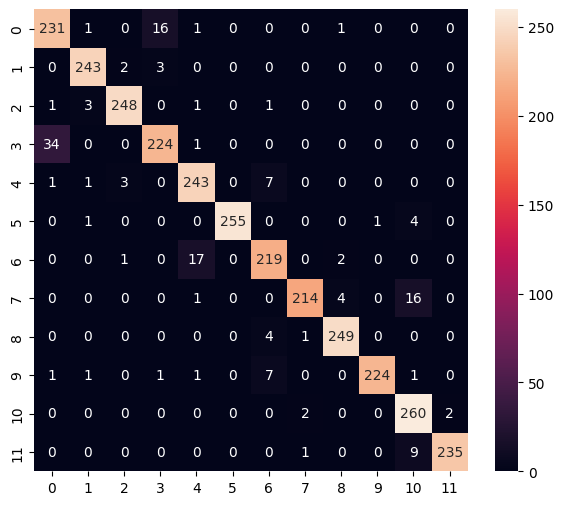

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       250
           1       0.97      0.98      0.98       248
           2       0.98      0.98      0.98       254
           3       0.92      0.86      0.89       259
           4       0.92      0.95      0.93       255
           5       1.00      0.98      0.99       261
           6       0.92      0.92      0.92       239
           7       0.98      0.91      0.94       235
           8       0.97      0.98      0.98       254
           9       1.00      0.95      0.97       236
          10       0.90      0.98      0.94       264
          11       0.99      0.96      0.98       245

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000



In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

# Y_pred = model.predict(X_test)
# y_pred = np.argmax(Y_pred, axis=1)

y_pred = integrated_prediction(model, secondary_model, X_test)  # Integrated prediction

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [23]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

c:\Users\Ian\git\553.806_Capstone_HandGesture\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Ian\AppData\Local\Temp\tmp1068wc5f\assets


INFO:tensorflow:Assets written to: C:\Users\Ian\AppData\Local\Temp\tmp1068wc5f\assets


40248

In [25]:
# Save secondary model

# secondary_model.save(model_save_path, include_optimizer=False)

In [26]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(secondary_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path2, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Ian\AppData\Local\Temp\tmpscg6v5zg\assets


INFO:tensorflow:Assets written to: C:\Users\Ian\AppData\Local\Temp\tmpscg6v5zg\assets


8984

# Inference test

In [27]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [28]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [29]:
X_test[0][0].shape

()

In [30]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [31]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [32]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.3103730e-14 1.0000000e+00 5.9158520e-19 1.0268541e-24 8.2806551e-15
 7.4813711e-09 2.4880724e-19 3.0076581e-08 2.6693600e-14 2.9259244e-11
 1.4153912e-12 1.3714222e-17]
1
